In [2]:
from torch.utils.data import DataLoader 
import torch
import matplotlib.pyplot as plt
from pyscf import gto, dft, scf 
from kspies import wy, zmp
from dpyscfl.scf import *
from dpyscfl.net import *
from dpyscfl.utils import *
import os, shutil, copy
from ase import Atoms
from ase.units import Bohr, Hartree
import pickle
from ase.io import read, write
from torchviz import make_dot
import pylibnxc

In [3]:
ref = read('/home/awills/Documents/Research/swxcd/seawulf/g2_97_3/results.traj', ':')
xcdp = '/home/awills/Documents/Research/swxcd/eval/xcdiff/g2_97/preds_2'
xcdcp = '/home/awills/Documents/Research/swxcd/eval/xcdiff_c/g2_97/preds_d2tzvpd'
xcdcpd = '/home/awills/Documents/Research/swxcd/eval/xcdiff_c/g2_97/predsdoub_d2tzvpd'
xcdsw1 = '/home/awills/Documents/Research/swxcd/eval/xcdsw1/g2_97/preds_d2tzvpd'
xcdsw3 = '/home/awills/Documents/Research/swxcd/eval/xcdsw3/g2_97/preds_d2tzvpd'
xcdsw12 = '/home/awills/Documents/Research/swxcd/eval/xcdsw1/g2_97/preds2_d2tzvpd'
xcdsw32 = '/home/awills/Documents/Research/swxcd/eval/xcdsw3/g2_97/preds2_d2tzvpd'
xcdsf1 = '/home/awills/Documents/Research/swxcd/eval/xcdsymfrac/abfrac/swmg1/g2_97/preds_d2tzvpd'
xcdsf3 = '/home/awills/Documents/Research/swxcd/eval/xcdsymfrac/abfrac/swmg3/g2_97/preds_d2tzvpd'
xcdsf12 = '/home/awills/Documents/Research/swxcd/eval/xcdsymfrac/abfrac/swmg1/g2_97/preds2_d2tzvpd'
xcdsf32 = '/home/awills/Documents/Research/swxcd/eval/xcdsymfrac/abfrac/swmg3/g2_97/preds2_d2tzvpd'

pts = '/home/awills/Documents/Research/swxcd/eval/ptscan/g2_97/preds_d2tzvpd'
pts2 = '/home/awills/Documents/Research/swxcd/eval/ptscan/g2_97/preds2_d2tzvpd'
ptsd = '/home/awills/Documents/Research/swxcd/eval/ptscan/double/g2_97/preds_d2tzvpd'
ptsd2 = '/home/awills/Documents/Research/swxcd/eval/ptscan/double/g2_97/preds2_d2tzvpd'

#paths = [xcdp, xcdfp, RFP, FRP, FR1P, xcdcp]
paths = [xcdp, xcdcp, xcdcpd, xcdsw1, xcdsw12, xcdsw3, xcdsw32, xcdsf1, xcdsf3, xcdsf12, xcdsf32,
        pts, pts2, ptsd, ptsd2]
es = {p:[] for p in paths}
ref_es = [at.calc.results['energy']/Hartree for at in ref]
for idx,atom in enumerate(ref):
    pckl = '{}_{}.pckl'.format(idx, atom.symbols)
    for key in list(es.keys()):
        if idx == 0:
            print(key)
        with open(key+'/{}'.format(pckl), 'rb') as f:
            e = pickle.load(f)
        es[key].append(e['E'])

n_atoms = [len(at.positions) for at in ref]
def mse(ref_es, pred_es, n_atoms):
    err = []
    for idx in range(len(ref_es)):
        ref = ref_es[idx]
        pred = pred_es[idx]
        nat = n_atoms[idx]
        err.append((ref-pred)**2)
    mse = np.mean(err)
    std = np.std(err)
    return ([np.sqrt(ierr) for ierr in err], mse, std)

/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/ase/io/jsonio.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(obj)


/home/awills/Documents/Research/swxcd/eval/xcdiff/g2_97/preds_2
/home/awills/Documents/Research/swxcd/eval/xcdiff_c/g2_97/preds_d2tzvpd
/home/awills/Documents/Research/swxcd/eval/xcdiff_c/g2_97/predsdoub_d2tzvpd
/home/awills/Documents/Research/swxcd/eval/xcdsw1/g2_97/preds_d2tzvpd
/home/awills/Documents/Research/swxcd/eval/xcdsw1/g2_97/preds2_d2tzvpd
/home/awills/Documents/Research/swxcd/eval/xcdsw3/g2_97/preds_d2tzvpd
/home/awills/Documents/Research/swxcd/eval/xcdsw3/g2_97/preds2_d2tzvpd
/home/awills/Documents/Research/swxcd/eval/xcdsymfrac/abfrac/swmg1/g2_97/preds_d2tzvpd
/home/awills/Documents/Research/swxcd/eval/xcdsymfrac/abfrac/swmg3/g2_97/preds_d2tzvpd
/home/awills/Documents/Research/swxcd/eval/xcdsymfrac/abfrac/swmg1/g2_97/preds2_d2tzvpd
/home/awills/Documents/Research/swxcd/eval/xcdsymfrac/abfrac/swmg3/g2_97/preds2_d2tzvpd
/home/awills/Documents/Research/swxcd/eval/ptscan/g2_97/preds_d2tzvpd
/home/awills/Documents/Research/swxcd/eval/ptscan/g2_97/preds2_d2tzvpd
/home/awills/Do

In [4]:
errd = {key: mse(ref_es, val, n_atoms) for key,val in es.items()}
labels = {xcdp: 'XCDiff',
          xcdcp:'XCDiff (Continued, 18 Epochs)',
          xcdcpd:'XCDiff (Continued, Double Prec.)',
          xcdsw1:'XCDiff+HB/PT (Grid 1)',
          xcdsw12:'XCDiff+HB/PT (Grid 1, 2 Days)',
          xcdsw3:'XCDiff+HB/PT (Grid 3)',
          xcdsw32:'XCDiff+HB/PT (Grid 3, 2 Days)',
         xcdsf1: 'XCDiff+F (Full Net, Grid 1)',
       xcdsf3: 'XCDiff+F (Full Net, Grid 3)',
         xcdsf12: 'XCDiff+F (Continued, Grid 1)',
       xcdsf32: 'XCDiff+F (Continued, Grid 3)',
         pts:'Pre-Train SCAN Start',
         pts2:'Pre-Train SCAN Start (Continued)',
         ptsd:'Pre-Train SCAN Start (Double)',
         ptsd2:'Pre-Train SCAN Start (Double, Continued)'}

def errcomp(err1, err2, atoms):
    inds = [i for i in range(len(e1)) if e1[i] < e2[i] ]
    better = [atoms[i] for i in inds]
    return better

In [9]:
e1 = errd[xcdsw32][0]
e2 = errd[xcdp][0]
b = errcomp(e1, e2, ref)
bf = [ib.get_chemical_formula() for ib in b]
','.join(bf)

'CO,HF,CO2,H2O,CHO,N2O,NO2,CHF3,CF2O,CH2O,H2O2,CH2O2,C2F3N,CH2F2,CH3O,C2H2O,C2H4O2,NO,C2H4O2,CH3NO2,C2H5NO,C2H3FO,C2H3F,HO,N2,O2,CH3NO2,C2H2O2,O3'

/home/awills/Documents/Research/swxcd/eval/xcdiff/g2_97/preds_2 0.003096511376351026 0
XCDiff:
0.0031
/home/awills/Documents/Research/swxcd/eval/xcdiff_c/g2_97/preds_d2tzvpd 0.076323711272367 1
XCDiff (Continued, 18 Epochs):
0.0763
/home/awills/Documents/Research/swxcd/eval/xcdiff_c/g2_97/predsdoub_d2tzvpd 0.08739349792690948 2
XCDiff (Continued, Double Prec.):
0.0874
/home/awills/Documents/Research/swxcd/eval/xcdsw1/g2_97/preds_d2tzvpd 0.13611175905445214 3
XCDiff+HB/PT (Grid 1):
0.1361
/home/awills/Documents/Research/swxcd/eval/xcdsw1/g2_97/preds2_d2tzvpd 0.20221368352047445 4
XCDiff+HB/PT (Grid 1, 2 Days):
0.2022
/home/awills/Documents/Research/swxcd/eval/xcdsw3/g2_97/preds_d2tzvpd 0.06027217343528113 5
XCDiff+HB/PT (Grid 3):
0.0603
/home/awills/Documents/Research/swxcd/eval/xcdsw3/g2_97/preds2_d2tzvpd 0.12942933733179193 6
XCDiff+HB/PT (Grid 3, 2 Days):
0.1294
/home/awills/Documents/Research/swxcd/eval/xcdsymfrac/abfrac/swmg1/g2_97/preds_d2tzvpd 0.19018296876037788 7
XCDiff+F (Full

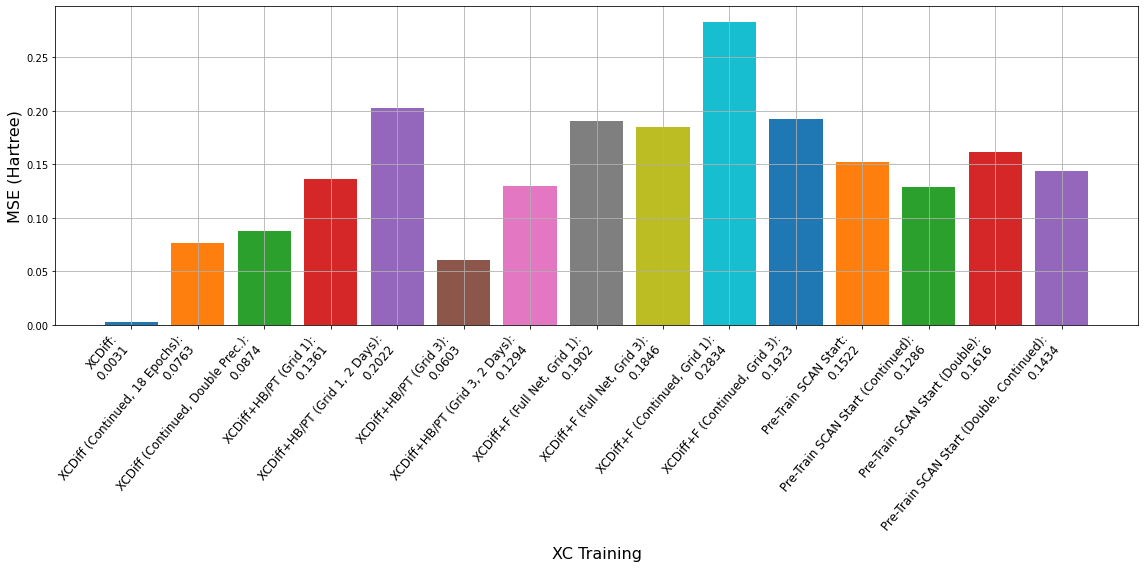

In [18]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(111)
count = 0
xtlabs = []
ax.grid()
for k,v in errd.items():
    print(k, v[1], count)
    lab = labels[k]+':\n{:3.4f}'.format(v[1])
    print(lab)
    ax.bar(count, v[1], label=lab)
    xtlabs.append(lab)
    count += 1
ax.set_xticks(np.arange(0, count))
ax.set_xticklabels(xtlabs, fontsize=12, rotation=50, ha='right')
ax.set_ylabel("MSE (Hartree)", fontsize=16)
ax.set_xlabel("XC Training", fontsize=16)
plt.tight_layout()

In [13]:
np.arange(1, count)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

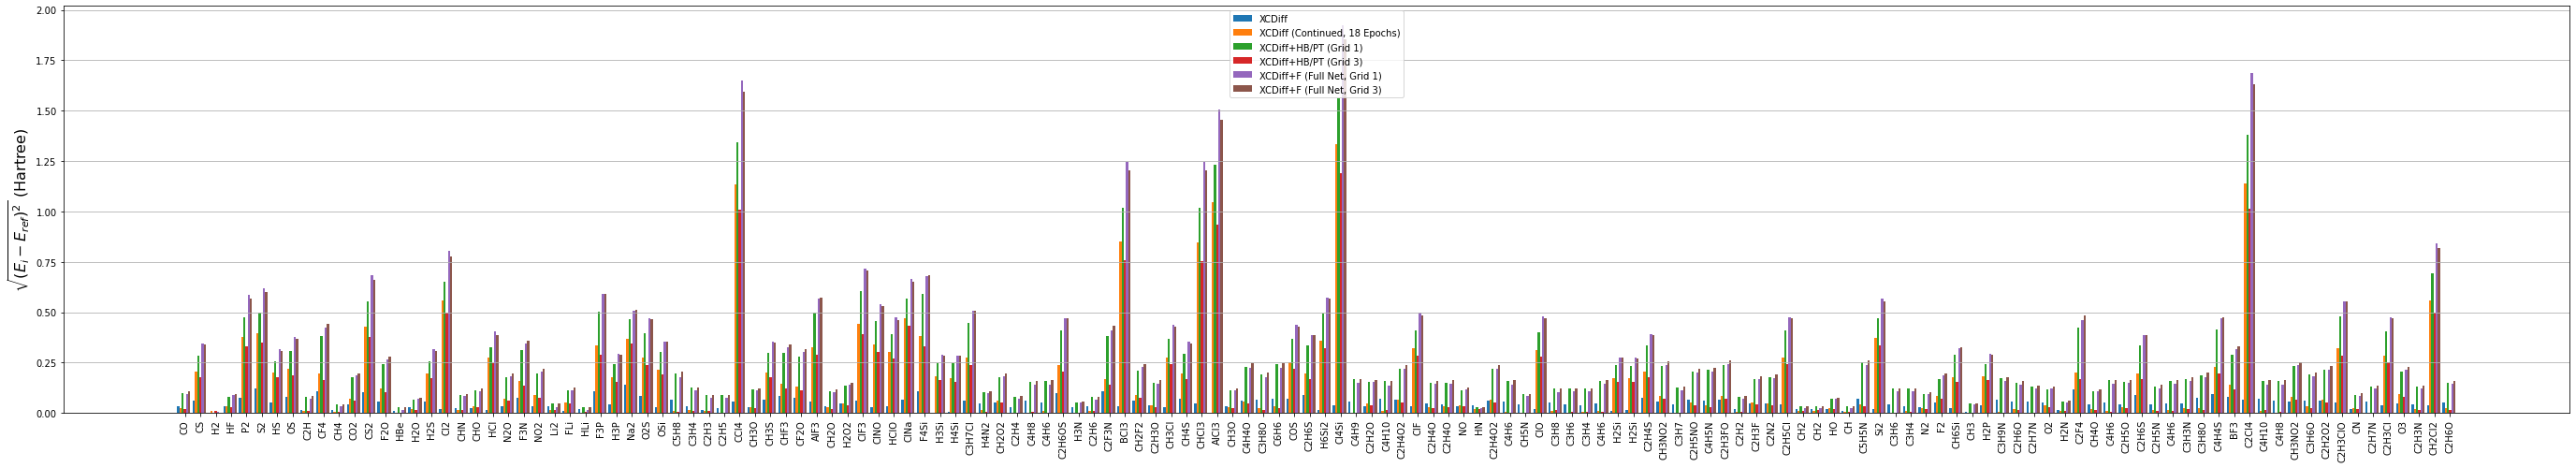

In [27]:
f = plt.figure(figsize=(48,8))
ax = f.add_subplot(111)
ax.grid()
ax.xaxis.grid(False)
def gen_xs_bar(*args, **kwargs):
    midsep = kwargs.get('midsep', 1)
    width = kwargs.get('width', midsep/(len(args)+2))
    xs = []
    start = -len(args)//2
    for iarg in range(len(args)):
        arg = args[iarg]
        argxs = []
        for igroup in range(len(arg)):
            argxs.append(igroup*midsep+start*width)
        start += 1
        xs.append(argxs)
    return xs
midsep = len(errd)+1
width = 1
errs = [(labels[k], errd[k][0]) for k in sorted(list(errd.keys()))]
labs = [i[0] for i in errs]
errp = [i[1] for i in errs]
xs = gen_xs_bar(*errp, width=width, midsep=midsep)
for i in range(len(xs)):
    x = xs[i]
    e = errp[i]
    ax.bar(x, e, width=width, label=labs[i])
ax.set_xticks([midsep*i for i in range(len(ref))])
ax.set_xticklabels([at.get_chemical_formula() for at in ref], rotation=90)
ax.set_ylabel('$\\sqrt{(E_i-E_{ref})^2}$ (Hartree)', fontsize=16)
plt.legend(loc='upper center')
plt.show()

In [14]:
x

[-0.3, 1.2, 2.7, 4.2, 5.7, 7.2]